# Tutorial 6, Diagonal integration of the spatial transcriptomics and metabolomics of the human liver

In [1]:
import sys
sys.path.append(r"/home/wangheqi/PycharmProject/")

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np

import matplotlib.pyplot as plt
import spcoral
import random
import torch

random.seed(2030)
np.random.seed(2030)

### Read the data

The Stereo-seq transcriptomics and MALDI-2 metabolomics data from normal human liver tissue were kindly provided by our collaborators and are available after publishment.

In [2]:
adata_rna = sc.read_h5ad('/csb3/project/wangheqi_meta/data/hui_lab_data/Y01043K6.lasso.bin50_scanpy_raw.h5ad')
adata_smi = sc.read_h5ad('/csb3/project/wangheqi_meta/data/hui_lab_data/Y01043K6.h5ad')

Make a copy of the original data.

In [3]:
adata_rna_raw = adata_rna.copy()
adata_smi_raw = adata_smi.copy()

### Preprocessing for alignment 1: Screening of spatial marker genes

In [4]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_rna)
# Logarithmize the data
sc.pp.log1p(adata_rna)

Previous studies have shown that, compared to small-moleculer matebolites, lipids better capture cell type spectific differences. Accordingly, here we only retained peaks with high m/z.

In [5]:
adata_smi = adata_smi[:, adata_smi.var_names[1000: ]].copy()

We employed the global moran's I to select spatially autocorrelated genes.

In [6]:
adata_smi = spcoral.pp.calculate_global_moran(adata_smi, k=25, n_jobs=10, alpha=0.05, I_cut=0.2)

Building spatial weights matrix using K-nearest neighbors (k=25)
Using default expression matrix (.X)
Starting computation of global Moran's I for 1285 genes...
Using 10 parallel processes
Automatically set batch size: 12


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:   28.8s
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed:   53.5s
[Parallel(n_jobs=10)]: Done  80 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 164 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 272 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 380 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done 512 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 644 tasks      | elapsed:  5.8min
[Parallel(n_jobs=10)]: Done 800 tasks      | elapsed:  7.0min
[Parallel(n_jobs=10)]: Done 956 tasks      | elapsed:  8.1min
[Parallel(n_jobs=10)]: Done 1136 tasks      | elapsed:  9.4min
[Parallel(n_jobs=10)]: Done 1228 tasks      | elapsed: 10.5min
[Parallel(n_jobs=10)]: Done 1245 tasks      | elapsed: 12.0min
[Parallel(n_jobs=10)]: Done 1262 tasks      | elapsed: 13.4min
[Parallel(n_jobs=10)]: Done 1285 out of 1285 | elap

After multiple testing correction (fdr_bh), number of significant genes: 1269
Found 155 genes with significant spatial autocorrelation (p < 0.05)
Top genes by Moran's I:
  1. 742.5391154: I=0.800, p=0.000e+00
  2. 436.2851459: I=0.791, p=0.000e+00
  3. 766.5389565: I=0.790, p=0.000e+00
  4. 419.2578272: I=0.782, p=0.000e+00
  5. 346.0579494: I=0.777, p=0.000e+00
  6. 762.5099257: I=0.756, p=0.000e+00
  7. 885.5513006: I=0.749, p=0.000e+00
  8. 391.2262875: I=0.748, p=0.000e+00
  9. 768.5537627: I=0.740, p=0.000e+00
  10. 886.556971: I=0.731, p=0.000e+00


In [7]:
sc.pp.scale(adata_smi, max_value=5)

### Preprocessing for alignment 2: Downsampling the original data

Given the high resolution of spots in the raw data, direct training on the full dataset was infeasible. Therefore, we adopted a downsampling approach: the transformation matrix was computed on the downsampled data and subsequently applied to the original resolution data.

In [8]:
adata_rna_bin = spcoral.pp.downsampling(adata_rna, resolution=200, method='mean', drop_min=10)
adata_smi_bin = spcoral.pp.downsampling(adata_smi, resolution=100, method='mean', drop_min=10)

In [9]:
sc.pp.highly_variable_genes(adata_rna_bin, flavor='seurat_v3', n_top_genes=3000)
adata_rna_bin = adata_rna_bin[:, adata_rna_bin.var['highly_variable'] == True].copy()

In [10]:
sc.pp.scale(adata_rna_bin, max_value=2)
sc.pp.pca(adata_rna_bin, n_comps=50)
sc.pp.neighbors(adata_rna_bin, n_pcs=30)
sc.tl.louvain(adata_rna_bin)

In [11]:
sc.pp.scale(adata_smi_bin, max_value=2)
sc.pp.pca(adata_smi_bin, n_comps=50)
sc.pp.neighbors(adata_smi_bin, n_pcs=30)
sc.tl.louvain(adata_smi_bin)

In [12]:
adata_rna_bin.obsm['feat'] = adata_rna_bin.X
adata_smi_bin.obsm['feat'] = adata_smi_bin.X

### Traning of the alignment model

In [13]:
Model = spcoral.model.regist_model(
    adata_omics1 = adata_rna_bin,
    adata_omics2 = adata_smi_bin,
    graph_method = 'radius',
    radius_spatial_omics1 = 1.1,
    radius_spatial_omics2 = 1.1,
    alpha = 0.1,
    epochs=100,
    random_seed=2030,
    device = torch.device('cuda:0'),
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


In [14]:
adata_rna_bin, adata_smi_bin, loss_list = Model.train()

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.79it/s]


In [15]:
adata_rna_bin, registering_parameters = spcoral.model.registration(adata_rna_bin, adata_smi_bin, n_iter=0, beta=0.9, 
                                                 method='rigid'
                                                )

The number of anchors is 3132


### Mapping the transformation matrix to the raw data

In [16]:
adata_rna_raw, adata_smi_raw = spcoral.model.registration_by_downsampling(
    adata_rna_raw, adata_smi_raw, adata_rna_bin, adata_smi_bin,
)

### Show the results of alignment model

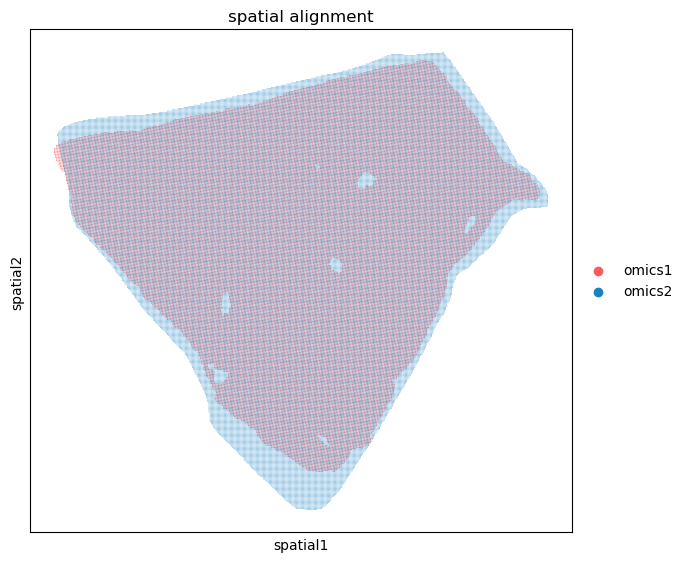

In [17]:
%matplotlib inline
spcoral.plot.show_cross_align(adata_rna_raw, adata_smi_raw, omics1_use_obsm='spatial_reg_raw', omics2_use_obsm='spatial_reg_raw')

### Preprocessing for integration

Due to significant noise in the matebolomics data at the tissue edges, which would impact integration, we restricted the input to the central region of the tissue for the integration model.

In [18]:
adata_rna_part = spcoral.pp.extract_spatial_region(adata_rna_raw, minx=25, miny=25, maxx=65, maxy=65, used_obsm='spatial_reg_bin')
adata_smi_part = spcoral.pp.extract_spatial_region(adata_smi_raw, minx=25, miny=25, maxx=65, maxy=65, used_obsm='spatial_reg_bin')

In [19]:
sc.pp.highly_variable_genes(adata_rna_part, flavor='seurat_v3', n_top_genes=1000)
adata_rna_part = adata_rna_part[:, adata_rna_part.var['highly_variable'] == True].copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata_rna_part)
# Logarithmize the data
sc.pp.log1p(adata_rna_part)

In [20]:
sc.pp.highly_variable_genes(adata_smi_part, flavor='seurat_v3', n_top_genes=1000)
adata_smi_part = adata_smi_part[:, adata_smi_part.var['highly_variable'] == True].copy()

sc.pp.scale(adata_smi_part)

In [21]:
sc.pp.pca(adata_rna_part, n_comps=80)
sc.pp.pca(adata_smi_part)

### Show the domains of clustering separately using the transcriptomics and metabolomics data.

In [22]:
sc.pp.neighbors(adata_rna_part, n_neighbors=30)
sc.tl.louvain(adata_rna_part, flavor="vtraag", resolution=1.0)

In [23]:
sc.pp.neighbors(adata_smi_part, n_neighbors=30)
sc.tl.louvain(adata_smi_part, flavor="vtraag", resolution=0.5)

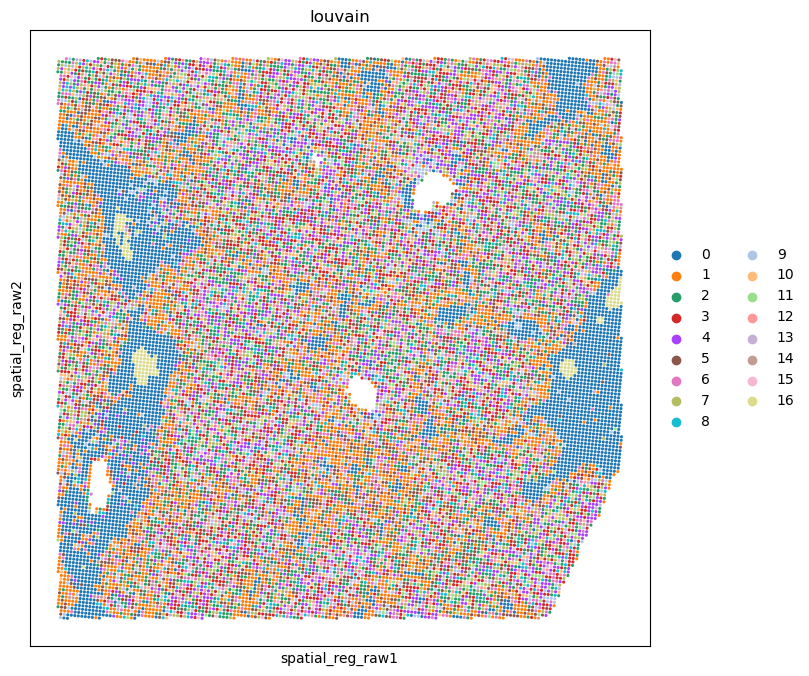

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

sc.pl.embedding(adata_rna_part, basis='spatial_reg_raw', color='louvain', ax=ax, s=20)

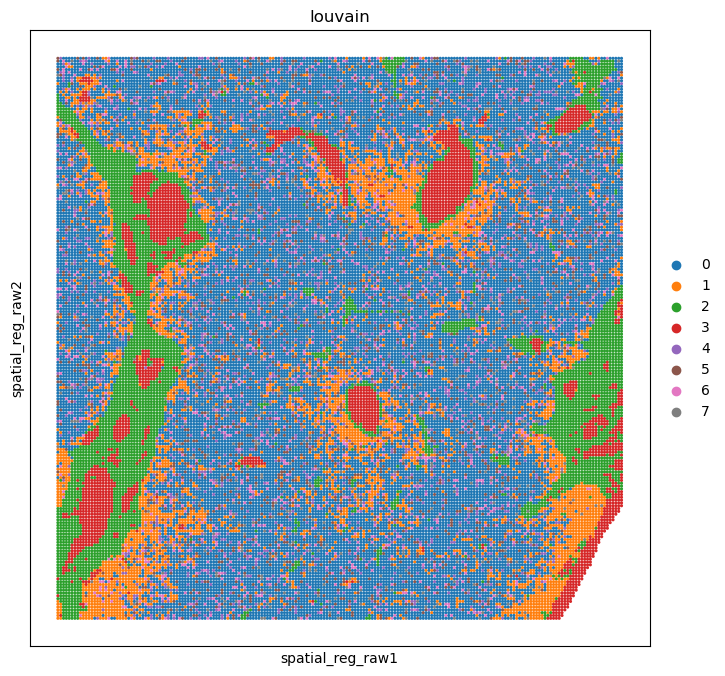

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

sc.pl.embedding(adata_smi_part, basis='spatial_reg_raw', color='louvain', ax=ax, s=20)

In [26]:
adata_rna_part.obsm['feat'] = adata_rna_part.obsm['X_pca']
adata_smi_part.obsm['feat'] = adata_smi_part.obsm['X_pca']

### Segmentation

Given the high density of spots in the original data, we segmented it into patch-like subsets to use as model input.

In [27]:
clip_results = spcoral.pp.clipping_patch(adata_omics1 = adata_rna_part, adata_omics2 = adata_smi_part,
                              use_obsm = 'spatial_reg_raw', x_num=4, y_num=4, min_cells=50
                             )

### Traning of the integration model

In [28]:
Model = spcoral.model.integrate_model_block(
    clip_results,
    epochs=100,
    device=torch.device('cuda:3'),
    random_seed=2030
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


In [29]:
Model.preprocess(
    graph_method_single='radius',
    radius_spatial_omics1=0.31,
    radius_spatial_omics2=0.31,
    num_processes=5,
    k_cross_omics=8,
    k_all_omics=15,
    use_obsm='spatial_reg_bin',
    g_all_auto=False,
)

Preprocessing blocks with 5 processes: 100%|██████████████████████████████████████████████████████████| 16/16 [07:04<00:00, 26.52s/it]


In [30]:
Model.train()
adata_rna_part, adata_smi_part = Model.map_results_to_adata()

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


Mapping blocks: 100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


### Dissect the spatial domain

In [34]:
adata_rna_part, adata_smi_part = spcoral.analysis.cluster(adata_rna_part, adata_smi_part, cluster_method='louvain', resolution_louvain=0.8)

### Visualization of spatial domain

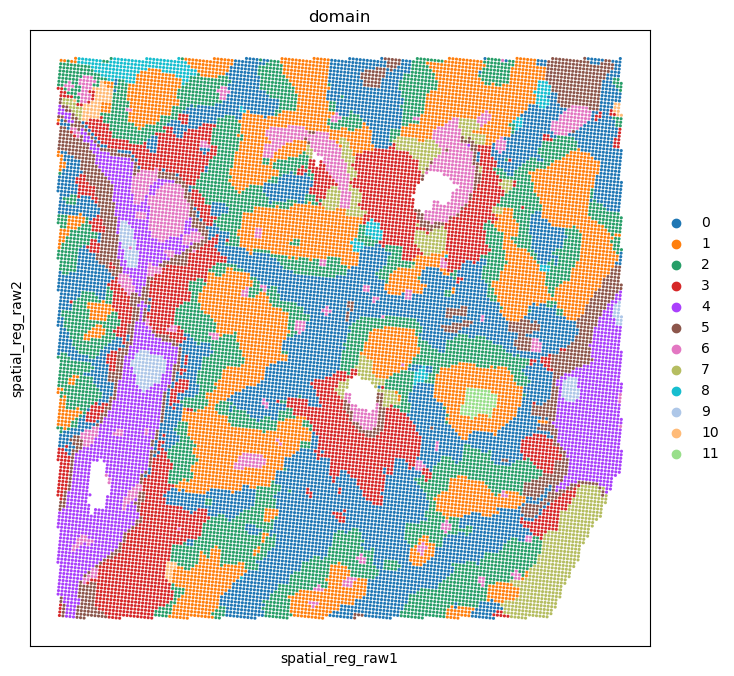

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

sc.pl.embedding(adata_rna_part, basis='spatial_reg_raw', color='domain', ax=ax, s=20)

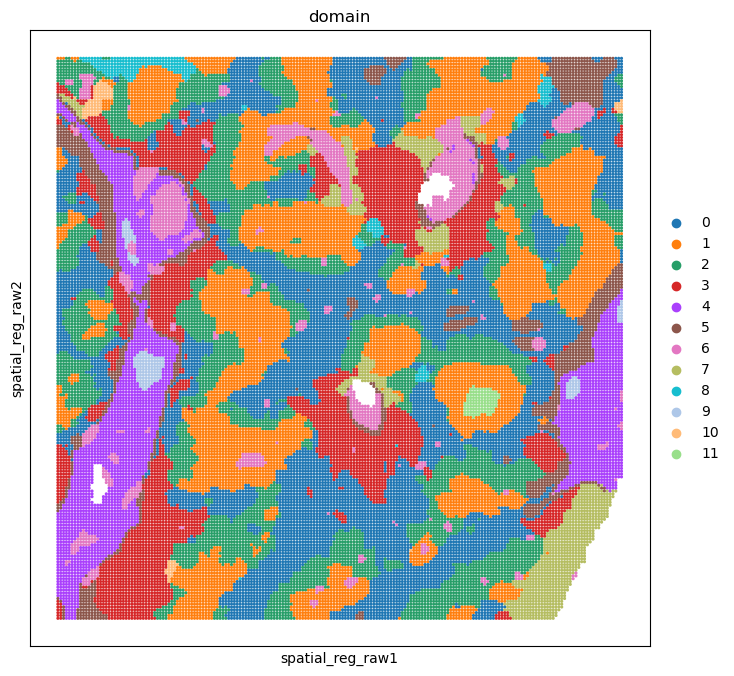

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

sc.pl.embedding(adata_smi_part, basis='spatial_reg_raw', color='domain', ax=ax, s=20)